<a href="https://colab.research.google.com/github/ShethNidhi06/Twitter_Data/blob/main/psg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as mp

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Twitter_Data.csv to Twitter_Data.csv


In [ ]:

import io
data = io.BytesIO(uploaded['Twitter_Data.csv']) 

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.2 MB/s 
     |████████████████████████████████| 101 kB 6.8 MB/s 
     |████████████████████████████████| 6.6 MB 41.1 MB/s 
     |████████████████████████████████| 596 kB 63.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
politics_df=pd.read_csv("Twitter_Data.csv")

politics_df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


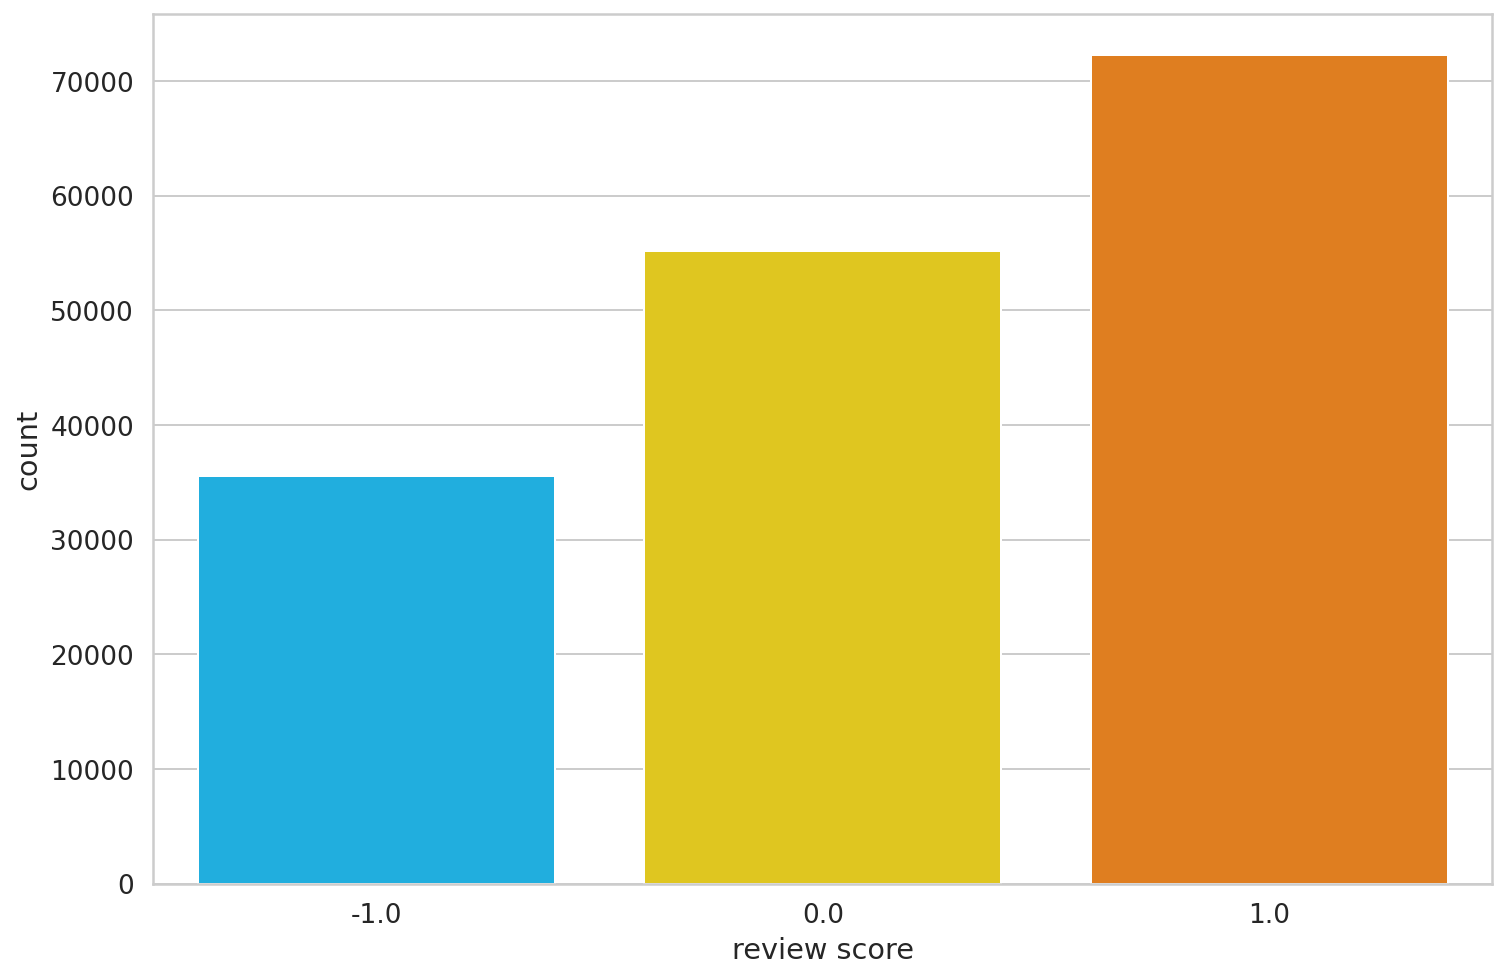

In [ ]:
sns.countplot(politics_df.category)
plt.xlabel('review score');

In [ ]:
politics_df.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
162975    False
162976    False
162977    False
162978    False
162979    False
Length: 162980, dtype: bool

In [ ]:
politics_df = politics_df.apply(lambda x: x.str.lower() if x.dtype == "object" else x) 
politics_df

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0


In [ ]:
import numpy as np
import re
 
def clean_tweet(temp):
    if type(temp) == np.float64:
        return ""
    temp = temp.lower()
    temp=re.sub("b'","",temp)
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)
    return temp

In [ ]:
politics_df['clean_tweet'] = politics_df['clean_text'].astype(str).apply(lambda x:clean_tweet(x))
politics_df

,clean_text,category,clean_tweet
0,when modi promised “minimum government maximum...,-1.0,when modi promised minimum government maximum...
1,talk all the nonsense and continue all the dra...,0.0,talk all the nonsense and continue all the dra...
2,what did just say vote for modi welcome bjp t...,1.0,what did just say vote for modi welcome bjp t...
3,asking his supporters prefix chowkidar their n...,1.0,asking his supporters prefix chowkidar their n...
4,answer who among these the most powerful world...,1.0,answer who among these the most powerful world...
...,...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1.0,why these 456 crores paid neerav modi not reco...
162976,dear rss terrorist payal gawar what about modi...,-1.0,dear rss terrorist payal gawar what about modi...
162977,did you cover her interaction forum where she ...,0.0,did you cover her interaction forum where she ...
162978,there big project came into india modi dream p...,0.0,there big project came into india modi dream p...


In [ ]:
def tokenization(text):
    text = re.split('\W+', text)
    return text

politics_df['Tweet_tokenized'] = politics_df['clean_tweet'].apply(lambda x: tokenization(x.lower()))
politics_df.head()

,clean_text,category,clean_tweet,Tweet_tokenized
0,when modi promised “minimum government maximum...,-1.0,when modi promised minimum government maximum...,"[when, modi, promised, minimum, government, ma..."
1,talk all the nonsense and continue all the dra...,0.0,talk all the nonsense and continue all the dra...,"[talk, all, the, nonsense, and, continue, all,..."
2,what did just say vote for modi welcome bjp t...,1.0,what did just say vote for modi welcome bjp t...,"[what, did, just, say, vote, for, modi, welcom..."
3,asking his supporters prefix chowkidar their n...,1.0,asking his supporters prefix chowkidar their n...,"[asking, his, supporters, prefix, chowkidar, t..."
4,answer who among these the most powerful world...,1.0,answer who among these the most powerful world...,"[answer, who, among, these, the, most, powerfu..."


In [ ]:
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
politics_df['Tweet_nonstop'] = politics_df['Tweet_tokenized'].apply(lambda x: remove_stopwords(x))
politics_df.head(10)

,clean_text,category,clean_tweet,Tweet_tokenized,Tweet_nonstop
0,when modi promised “minimum government maximum...,-1.0,when modi promised minimum government maximum...,"[when, modi, promised, minimum, government, ma...","[modi, promised, minimum, government, maximum,..."
1,talk all the nonsense and continue all the dra...,0.0,talk all the nonsense and continue all the dra...,"[talk, all, the, nonsense, and, continue, all,...","[talk, nonsense, continue, drama, vote, modi, ]"
2,what did just say vote for modi welcome bjp t...,1.0,what did just say vote for modi welcome bjp t...,"[what, did, just, say, vote, for, modi, welcom...","[say, vote, modi, welcome, bjp, told, rahul, m..."
3,asking his supporters prefix chowkidar their n...,1.0,asking his supporters prefix chowkidar their n...,"[asking, his, supporters, prefix, chowkidar, t...","[asking, supporters, prefix, chowkidar, names,..."
4,answer who among these the most powerful world...,1.0,answer who among these the most powerful world...,"[answer, who, among, these, the, most, powerfu...","[answer, among, powerful, world, leader, today..."
5,kiya tho refresh maarkefir comment karo,0.0,kiya tho refresh maarkefir comment karo,"[kiya, tho, refresh, maarkefir, comment, karo, ]","[kiya, tho, refresh, maarkefir, comment, karo, ]"
6,surat women perform yagna seeks divine grace f...,0.0,surat women perform yagna seeks divine grace f...,"[surat, women, perform, yagna, seeks, divine, ...","[surat, women, perform, yagna, seeks, divine, ..."
7,this comes from cabinet which has scholars lik...,0.0,this comes from cabinet which has scholars lik...,"[this, comes, from, cabinet, which, has, schol...","[comes, cabinet, scholars, like, modi, smriti,..."
8,with upcoming election india saga going import...,1.0,with upcoming election india saga going import...,"[with, upcoming, election, india, saga, going,...","[upcoming, election, india, saga, going, impor..."
9,gandhi was gay does modi,1.0,gandhi was gay does modi,"[gandhi, was, gay, does, modi, ]","[gandhi, gay, modi, ]"


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

politics_df['Tweet_lemmatized'] = politics_df['Tweet_nonstop'].apply(lambda x: lemmatizer(x))
politics_df.head()

,clean_text,category,clean_tweet,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized
0,when modi promised “minimum government maximum...,-1.0,when modi promised minimum government maximum...,"[when, modi, promised, minimum, government, ma...","[modi, promised, minimum, government, maximum,...","[modi, promised, minimum, government, maximum,..."
1,talk all the nonsense and continue all the dra...,0.0,talk all the nonsense and continue all the dra...,"[talk, all, the, nonsense, and, continue, all,...","[talk, nonsense, continue, drama, vote, modi, ]","[talk, nonsense, continue, drama, vote, modi, ]"
2,what did just say vote for modi welcome bjp t...,1.0,what did just say vote for modi welcome bjp t...,"[what, did, just, say, vote, for, modi, welcom...","[say, vote, modi, welcome, bjp, told, rahul, m...","[say, vote, modi, welcome, bjp, told, rahul, m..."
3,asking his supporters prefix chowkidar their n...,1.0,asking his supporters prefix chowkidar their n...,"[asking, his, supporters, prefix, chowkidar, t...","[asking, supporters, prefix, chowkidar, names,...","[asking, supporter, prefix, chowkidar, name, m..."
4,answer who among these the most powerful world...,1.0,answer who among these the most powerful world...,"[answer, who, among, these, the, most, powerfu...","[answer, among, powerful, world, leader, today...","[answer, among, powerful, world, leader, today..."


In [ ]:
ps = nltk.PorterStemmer()

def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

politics_df['Tweet_stemmed'] = politics_df['Tweet_lemmatized'].apply(lambda x: stemming(x))
politics_df.head()

,clean_text,category,clean_tweet,Tweet_tokenized,Tweet_nonstop,Tweet_lemmatized,Tweet_stemmed
0,when modi promised “minimum government maximum...,-1.0,when modi promised minimum government maximum...,"[when, modi, promised, minimum, government, ma...","[modi, promised, minimum, government, maximum,...","[modi, promised, minimum, government, maximum,...","[modi, promis, minimum, govern, maximum, gover..."
1,talk all the nonsense and continue all the dra...,0.0,talk all the nonsense and continue all the dra...,"[talk, all, the, nonsense, and, continue, all,...","[talk, nonsense, continue, drama, vote, modi, ]","[talk, nonsense, continue, drama, vote, modi, ]","[talk, nonsens, continu, drama, vote, modi, ]"
2,what did just say vote for modi welcome bjp t...,1.0,what did just say vote for modi welcome bjp t...,"[what, did, just, say, vote, for, modi, welcom...","[say, vote, modi, welcome, bjp, told, rahul, m...","[say, vote, modi, welcome, bjp, told, rahul, m...","[say, vote, modi, welcom, bjp, told, rahul, ma..."
3,asking his supporters prefix chowkidar their n...,1.0,asking his supporters prefix chowkidar their n...,"[asking, his, supporters, prefix, chowkidar, t...","[asking, supporters, prefix, chowkidar, names,...","[asking, supporter, prefix, chowkidar, name, m...","[ask, support, prefix, chowkidar, name, modi, ..."
4,answer who among these the most powerful world...,1.0,answer who among these the most powerful world...,"[answer, who, among, these, the, most, powerfu...","[answer, among, powerful, world, leader, today...","[answer, among, powerful, world, leader, today...","[answer, among, power, world, leader, today, t..."


In [ ]:
MODEL_NAME = 'bert-base-cased'


In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME) 

In [ ]:
token_lens = []

for txt in politics_df.clean_tweet:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

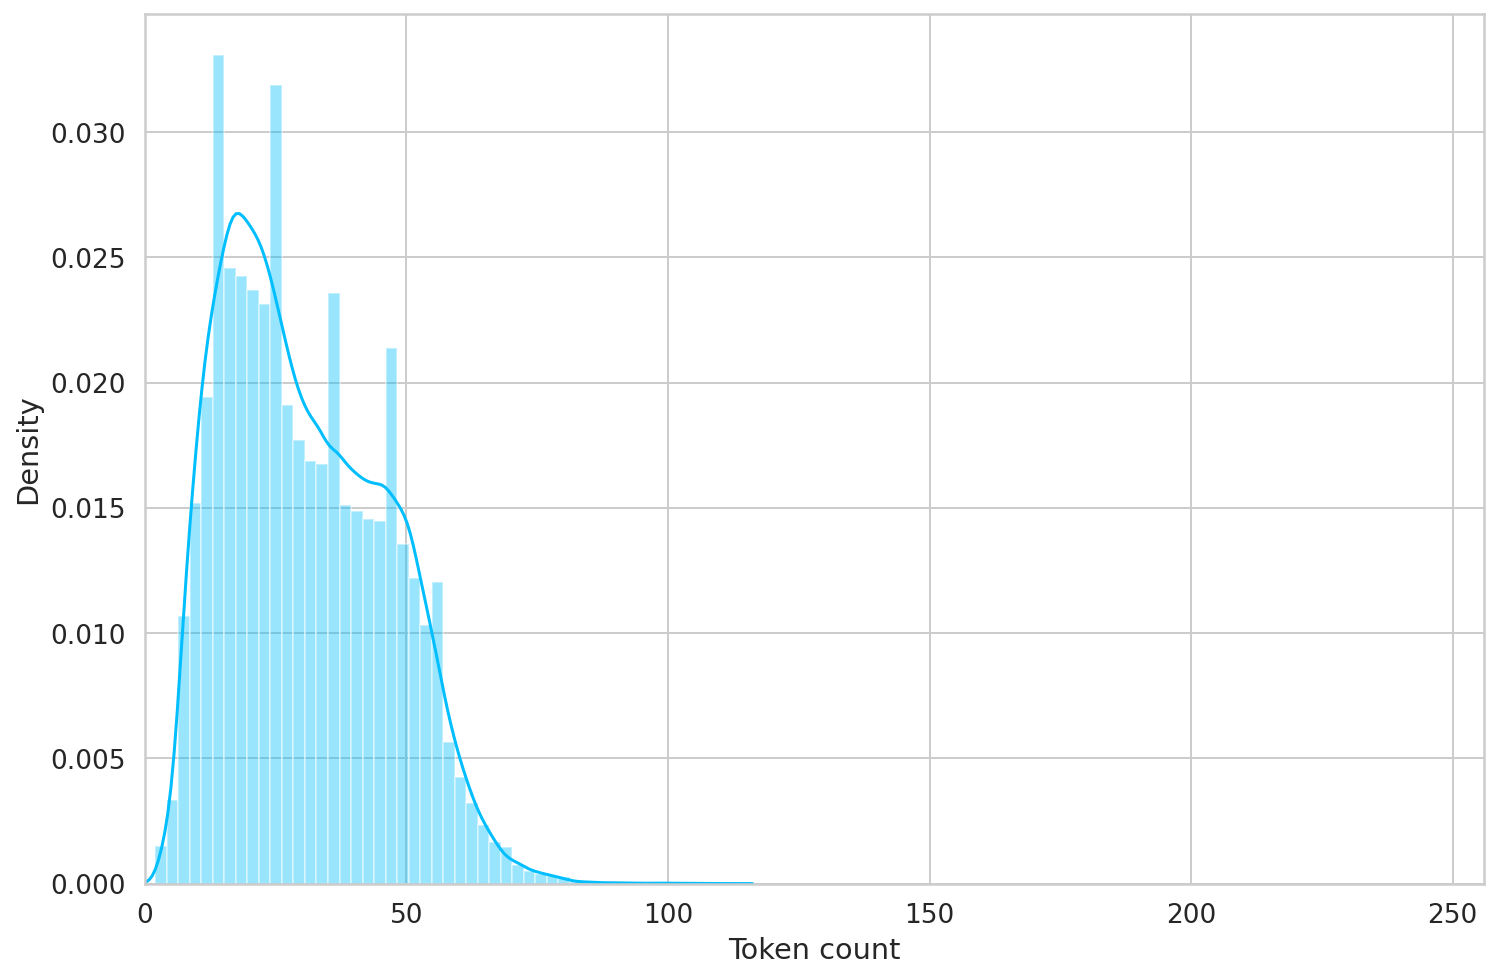

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 100

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
df_train, df_test = train_test_split(politics_df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((146682, 7), (8149, 7), (8149, 7))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
def convert_example_to_feature(review):
  return tokenizer.encode_plus(review,
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
              )


In [ ]:
# can be up to 512 for BERT
max_length = 512
batch_size = 6

In [ ]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

In [ ]:
def encode_examples(ds, limit=-1):
  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
  if (limit > 0):
      ds = ds.take(limit)
  for review, label in tfds.as_numpy(ds):
    bert_input = convert_example_to_feature(review.decode())
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])
  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [ ]:

df_train, df_test = train_test_split(politics_df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

NameError: ignored

In [ ]:
from transformers import TFBertForSequenceClassification
import tensorflow as tf
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5
# we will do just 1 epoch, though multiple epochs might be better as long as we will not overfit the model
number_of_epochs = 1
# model initialization
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:

bert_history = model.fit(df_train, epochs=6, validation_data=df_test)


ValueError: ignored

In [ ]:
639